In [1]:
###Import Packages###
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
from PIL import Image

from sklearn.model_selection import train_test_split
from skimage import io, color

import torch
from torch.utils.data  import Dataset, DataLoader
from torchvision import transforms
import torchvision.transforms.functional as TF
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from gensim.models import Word2Vec
import string
import ast

import re


##Upload Data and unzip them

In [2]:
# Connect to Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
basedir = "/content/drive/MyDrive/CSCI334301_ComputerVision/Project/Dataset/"

df = pd.read_csv(f'{basedir}annot.csv', low_memory = False)
# Remove rows contains only single period
df = df[df.utf8_string != "."]
# Remove all punctuations
df["utf8_string"] = df["utf8_string"].str.replace('[^\w\s]','',regex=True)
df["utf8_string"] = df["utf8_string"].str.upper()
# convert bbox to float list
df["bbox"] = df["bbox"].apply(ast.literal_eval)
# drop all str length larger than 100
df = df.drop(df[df.utf8_string.str.len() >= 100].index).dropna()
# Reset index
df=df.reset_index(drop=True)

df.head()

,Unnamed: 0,id,image_id,bbox,utf8_string,points,area
0,0,a4ea732cd3d5948a_1,a4ea732cd3d5948a,"[525.83, 3.4, 197.64, 33.94]",PERFORMANCE,"[525.83, 3.4, 723.47, 7.29, 722.76, 36.99, 525...",6707.90
1,1,a4ea732cd3d5948a_2,a4ea732cd3d5948a,"[534.67, 64.68, 91.22, 38.19]",SPORT,"[535.73, 64.68, 623.41, 67.51, 625.89, 102.87,...",3483.69
2,2,a4ea732cd3d5948a_3,a4ea732cd3d5948a,"[626.95, 63.62, 96.52, 31.82]",WATCH,"[626.95, 63.62, 721.7, 63.62, 723.47, 95.44, 6...",3071.27
3,3,a4ea732cd3d5948a_4,a4ea732cd3d5948a,"[577.4, 141.87, 147.13, 43.1]",PERIOD,"[580.02, 143.61, 724.53, 141.87, 723.66, 184.9...",6341.30
4,5,a4ea732cd3d5948a_6,a4ea732cd3d5948a,"[455.64, 204.45, 21.97, 24.82]",400,"[464.54, 204.45, 477.61, 221.88, 469.85, 229.2...",545.30


In [ ]:
# Find maximum bbox width and height
widthlist = []
heightlist = []
for i in range(len(df)):
  bbox = df.iloc[i,3]
  widthlist.append(bbox[2])
  heightlist.append(bbox[3])

print(f'Max Width: {max(widthlist)}')
print(f'Max height: {max(heightlist)}')

Max Width: 1023.51
Max height: 910.98


In [70]:
# Find the maximum label length
labellist = []
for i in range(len(df)):
  labellist.append(df.iloc[i, 4])
print(labellist[0])
print(labellist[1])
print(labellist[2])
maxlen = max(len(str(s)) for s in labellist)
print(maxlen)

PERFORMANCE
SPORT
WATCH
99


In [43]:
testchars = "abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ0123456789"
len(testchars)

62

#Loader

In [4]:
def pad_img(path, bbox=None):
  # read image
  img = Image.open(path).convert('RGB')
  img = np.array(img)
  #print(img.shape)
  if bbox != None:
    #top_left = [min(bbox[1], bbox[3]), min(bbox[0], bbox[2])]
    #bottom_right  = [max(bbox[1], bbox[3]), max(bbox[0], bbox[2])]
    top_left = [bbox[1], bbox[0]]
    bottom_right = [bbox[1]+bbox[3], bbox[0]+bbox[2]]
    img = img[ top_left[0]:bottom_right[0], top_left[1]:bottom_right[1] ] 
  old_image_height, old_image_width, channels = img.shape
  #print(img.shape)

  # create new image of desired size and color (blue) for padding
  new_image_width = 1024   # max width 1023.51  min 2.1
  new_image_height = 1024   # max height 910.98   min 1.9

  color = (0,0,0)
  result = np.full((new_image_height,new_image_width, channels), color, dtype=np.uint8)

  result[0:old_image_height, 0:old_image_width] = img

  return result

In [5]:
# Test Pad Image
imgp = pad_img(f'{basedir}train_val_images/train_images/a4ea732cd3d5948a.jpg', [525, 3, 197, 33])
#imgp = pad_img(f'{basedir}train_val_images/train_images/a4ea732cd3d5948a.jpg')
plt.imshow(imgp)

OSError: ignored

In [73]:
# Text OCR Dataloader 
import ast
rest_set_size = 0.3
test_set_size = 0.5
class dset(Dataset):
  def __init__(self, root_dir, train=True,test=True,transformX = None, transformY = None):
        #self.pixel_file = pd.read_csv(os.path.join(root_dir, 'sample.csv'))
        self.root_dir = root_dir
        self.transformX = transformX
        self.transformY = transformY
        self.train = train
        self.test = test


        annot_df = pd.read_csv(f'{self.root_dir}annot.csv', low_memory = False)
        # Remove rows contains only single period
        annot_df = annot_df[annot_df.utf8_string != "."][:2000]
        # Reset index
        annot_df=annot_df.reset_index(drop=True)
        # Remove rows contains special characters
        annot_df = annot_df.drop(annot_df[annot_df.utf8_string.str.contains(r'[^0-9a-zA-Z]', na=False)].index)
        # Reset index
        annot_df=annot_df.reset_index(drop=True)
        # drop all str length larger than 100
        annot_df = annot_df.drop(annot_df[annot_df.utf8_string.str.len() >= 100].index).dropna()
        # Reset index
        annot_df=annot_df.reset_index(drop=True)

        # Remove all punctuations
        annot_df["utf8_string"] = annot_df["utf8_string"].str.replace('[^\w\s]','',regex=True)
        # Make all upper case (no longer)
        #annot_df["utf8_string"] = annot_df["utf8_string"].str.upper()
        # convert bbox to float list
        annot_df["bbox"] = annot_df["bbox"].apply(ast.literal_eval)


        # Define the set of possible characters
        #chars = "ABCDEFGHIJKLMNOPQRSTUVWXYZ0123456789"
        chars = "abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ0123456789"

        # Create a dictionary to map each character to a unique integer
        self.char_to_int = {c: i for i, c in enumerate(chars)}
        self.int_to_char = {i: c for i, c in enumerate(chars)}
        print(self.char_to_int)
        #decoded = "".join(int_to_char[i] for i in encoded)


        # 70% tain, 15% valid, 15% test
        self.train_data, self.rest_data = train_test_split(annot_df, test_size = rest_set_size, random_state = 5)
        self.validation_data, self.test_data = train_test_split(annot_df, test_size = test_set_size, random_state = 5)

  def __len__(self):
    if self.train:
      length = len(self.train_data)
    elif self.test:
      length = len(self.test_data)
    else:
      length = len(self.validation_data)
    return length
  

  # for now, this will return:
  # X: the image (padded)
  # Y: encoded label
  def __getitem__(self, index):
    # retrieve row "image_id" from column index 2
    # Also retrieve bbox coordinates from column index 3
    filename = ""
    bbox = []
    if self.train:
      filename = self.train_data.iloc[index,2]
      bbox = [int(x) for x in self.train_data.iloc[index,3]]
    elif self.test:
      filename = self.test_data.iloc[index,2]
      #sliced = self.test_data.iloc[index,3][1:-1].split(", ")
      #bbox = [int(x) for x in sliced]
      bbox = [int(x) for x in self.test_data.iloc[index,3]]
    else:
      filename = self.validation_data.iloc[index,2]
      #sliced = self.validation_data.iloc[index,3][1:-1].split(", ")
      #bbox = [int(x) for x in sliced]
      bbox = [int(x) for x in self.validation_data.iloc[index,3]]
    


    imx = pad_img(f'{self.root_dir}train_val_images/train_images/{filename}.jpg', bbox)
    imT = (imx/255.0).T # This is image transposed and restricting values between 0 and 1


    if self.train:
      text = self.train_data.iloc[index,4]
    elif self.test:
      text = self.test_data.iloc[index,4]
    else:
      text = self.validation_data.iloc[index,4]
    
    # Encode Text
    clean_text = re.sub(r'[^\w\s]','',str(text))
    encoded_text = [self.char_to_int[c] for c in clean_text]
    # Pad with null characters [62]
    # Max label text length in the dataset: 320
    # but now we will use 100 haha
    for i in range(len(encoded_text), 100):
      encoded_text.append(62)


    encoded_text = torch.IntTensor(encoded_text)
    imT = torch.FloatTensor(imT)
    sample = {'image': imx, 'imageTransposed': imT, 'text': text, 'int_text': encoded_text}
    return sample


{'a': 0, 'b': 1, 'c': 2, 'd': 3, 'e': 4, 'f': 5, 'g': 6, 'h': 7, 'i': 8, 'j': 9, 'k': 10, 'l': 11, 'm': 12, 'n': 13, 'o': 14, 'p': 15, 'q': 16, 'r': 17, 's': 18, 't': 19, 'u': 20, 'v': 21, 'w': 22, 'x': 23, 'y': 24, 'z': 25, 'A': 26, 'B': 27, 'C': 28, 'D': 29, 'E': 30, 'F': 31, 'G': 32, 'H': 33, 'I': 34, 'J': 35, 'K': 36, 'L': 37, 'M': 38, 'N': 39, 'O': 40, 'P': 41, 'Q': 42, 'R': 43, 'S': 44, 'T': 45, 'U': 46, 'V': 47, 'W': 48, 'X': 49, 'Y': 50, 'Z': 51, '0': 52, '1': 53, '2': 54, '3': 55, '4': 56, '5': 57, '6': 58, '7': 59, '8': 60, '9': 61}
G
tensor([32, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62,
        62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62,
        62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62,
        62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62,
        62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62,
        62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 6

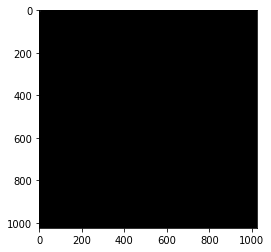

In [37]:
# Test dataset creation
basedir = "/content/drive/MyDrive/CSCI334301_ComputerVision/Project/Dataset/"
OCRdata = dset(basedir, train=True,test=False,)
data = OCRdata.__getitem__(157)

plt.imshow(data['image'])
print(data['text'])
print(data['int_text'])

[[[193 174 178]
  [193 184 177]
  [ 87  94  76]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]

 [[191 175 178]
  [190 186 177]
  [ 93 105  85]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]

 [[190 176 175]
  [189 186 181]
  [ 97 107  96]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]

 ...

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]]
SHOW
tensor([44, 33, 40, 48, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62,
        62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62,
        62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62,
        62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62,
        62, 62, 62, 62, 62, 62, 62, 62, 62, 6

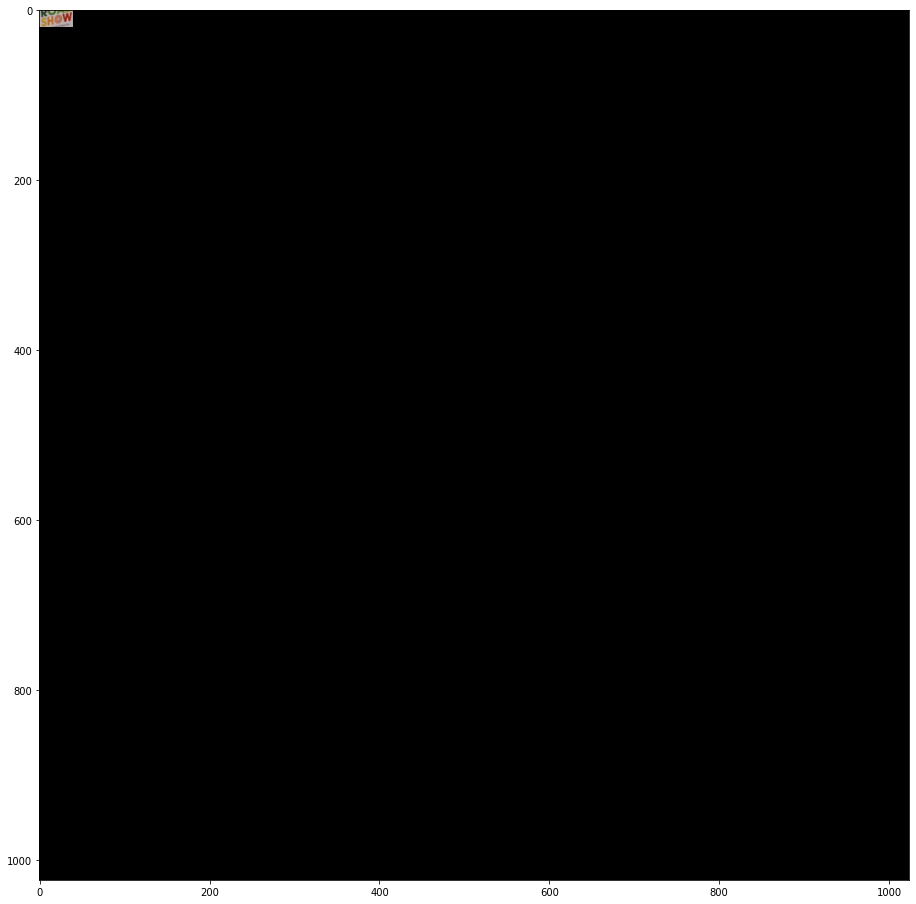

In [38]:
# Test dataset getitem
data = OCRdata.__getitem__(161)

plt.figure(figsize=(16,16))
plt.imshow(data['image'])
print(data['image'])
print(data['text'])
print(data['int_text'])
print(len(data['int_text']))
print(data['imageTransposed'].shape)

In [74]:
# Generate Dataset:
basedir = "/content/drive/MyDrive/CSCI334301_ComputerVision/Project/Dataset/"
###initialize data_loaders
tx_X = transforms.Compose([transforms.ToTensor(),
              transforms.Normalize((0.5,), (0.5,))])
tx_Y = transforms.Compose([transforms.ToTensor()
                        ])

# Generate Dataset
train_data = dset(basedir, train=True, test=False, transformX = tx_X, transformY = tx_Y)
validation_data = dset(basedir, train=False,test=False,transformX = tx_X, transformY = tx_Y)
test_data = dset(basedir, train=False, test=True,transformX = tx_X, transformY = tx_Y)

# Generate Dataloader
train_loader = DataLoader(dataset=train_data, batch_size=2, shuffle=True, num_workers=2)
validation_loader = DataLoader(dataset=validation_data, batch_size=2, shuffle=True, num_workers=1)
test_loader = DataLoader(dataset=test_data, batch_size=2, shuffle=True, num_workers=1)

{'a': 0, 'b': 1, 'c': 2, 'd': 3, 'e': 4, 'f': 5, 'g': 6, 'h': 7, 'i': 8, 'j': 9, 'k': 10, 'l': 11, 'm': 12, 'n': 13, 'o': 14, 'p': 15, 'q': 16, 'r': 17, 's': 18, 't': 19, 'u': 20, 'v': 21, 'w': 22, 'x': 23, 'y': 24, 'z': 25, 'A': 26, 'B': 27, 'C': 28, 'D': 29, 'E': 30, 'F': 31, 'G': 32, 'H': 33, 'I': 34, 'J': 35, 'K': 36, 'L': 37, 'M': 38, 'N': 39, 'O': 40, 'P': 41, 'Q': 42, 'R': 43, 'S': 44, 'T': 45, 'U': 46, 'V': 47, 'W': 48, 'X': 49, 'Y': 50, 'Z': 51, '0': 52, '1': 53, '2': 54, '3': 55, '4': 56, '5': 57, '6': 58, '7': 59, '8': 60, '9': 61}
{'a': 0, 'b': 1, 'c': 2, 'd': 3, 'e': 4, 'f': 5, 'g': 6, 'h': 7, 'i': 8, 'j': 9, 'k': 10, 'l': 11, 'm': 12, 'n': 13, 'o': 14, 'p': 15, 'q': 16, 'r': 17, 's': 18, 't': 19, 'u': 20, 'v': 21, 'w': 22, 'x': 23, 'y': 24, 'z': 25, 'A': 26, 'B': 27, 'C': 28, 'D': 29, 'E': 30, 'F': 31, 'G': 32, 'H': 33, 'I': 34, 'J': 35, 'K': 36, 'L': 37, 'M': 38, 'N': 39, 'O': 40, 'P': 41, 'Q': 42, 'R': 43, 'S': 44, 'T': 45, 'U': 46, 'V': 47, 'W': 48, 'X': 49, 'Y': 50, '

In [75]:
print('length')
print(len(train_loader))
print(len(validation_loader))
print(len(test_loader))

length
587
420
420


#Model

In [ ]:
import torch.nn as nn


class BidirectionalLSTM(nn.Module):

    def __init__(self, nIn, nHidden, nOut):
        super(BidirectionalLSTM, self).__init__()

        self.rnn = nn.LSTM(nIn, nHidden, bidirectional=True)
        self.embedding = nn.Linear(nHidden * 2, nOut)

    def forward(self, input):
        recurrent, _ = self.rnn(input)
        T, b, h = recurrent.size()
        t_rec = recurrent.view(T * b, h)

        output = self.embedding(t_rec)  # [T * b, nOut]
        output = output.view(T, b, -1)

        return output


class CRNN(nn.Module):

    def __init__(self, imgH, nc, nclass, nh, n_rnn=2, leakyRelu=False):
        super(CRNN, self).__init__()
        assert imgH % 16 == 0, 'imgH has to be a multiple of 16'

        ks = [3, 3, 3, 3, 3, 3, 2]
        ps = [1, 1, 1, 1, 1, 1, 0]
        ss = [1, 1, 1, 1, 1, 1, 1]
        nm = [64, 128, 256, 256, 512, 512, 512]

        cnn = nn.Sequential()

        def convRelu(i, batchNormalization=False):
            nIn = nc if i == 0 else nm[i - 1]
            nOut = nm[i]
            cnn.add_module('conv{0}'.format(i),
                           nn.Conv2d(nIn, nOut, ks[i], ss[i], ps[i]))
            if batchNormalization:
                cnn.add_module('batchnorm{0}'.format(i), nn.BatchNorm2d(nOut))
            if leakyRelu:
                cnn.add_module('relu{0}'.format(i),
                               nn.LeakyReLU(0.2, inplace=True))
            else:
                cnn.add_module('relu{0}'.format(i), nn.ReLU(True))

        convRelu(0)
        cnn.add_module('pooling{0}'.format(0), nn.MaxPool2d(2, 2))  # 64x16x64
        convRelu(1)
        cnn.add_module('pooling{0}'.format(1), nn.MaxPool2d(2, 2))  # 128x8x32
        convRelu(2, True)
        convRelu(3)
        cnn.add_module('pooling{0}'.format(2),
                       nn.MaxPool2d((2, 2), (2, 1), (0, 1)))  # 256x4x16
        convRelu(4, True)
        convRelu(5)
        cnn.add_module('pooling{0}'.format(3),
                       nn.MaxPool2d((2, 2), (2, 1), (0, 1)))  # 512x2x16
        convRelu(6, True)  # 512x1x16

        self.cnn = cnn
        self.rnn = nn.Sequential(
            BidirectionalLSTM(512, nh, nh),
            BidirectionalLSTM(nh, nh, nclass))

    def forward(self, input):
        # conv features
        conv = self.cnn(input)
        b, c, h, w = conv.size()
        print(conv.size())
        assert h == 1, "the height of conv must be 1"
        conv = conv.squeeze(2)
        conv = conv.permute(2, 0, 1)  # [w, b, c]

        # rnn features
        output = self.rnn(conv)

        return output

In [13]:
# Adapted from https://github.com/GitYCC/crnn-pytorch/blob/master/src/model.py
import torch.nn as nn


class CRNN2(nn.Module):

    def __init__(self, img_channel, img_height, img_width, num_class,
                 map_to_seq_hidden=64, rnn_hidden=256, leaky_relu=False):
        super(CRNN2, self).__init__()

        self.cnn, (output_channel, output_height, output_width) = \
            self._cnn_backbone(img_channel, img_height, img_width, leaky_relu)

        self.map_to_seq = nn.Linear(output_channel * output_height, map_to_seq_hidden)

        self.rnn1 = nn.LSTM(map_to_seq_hidden, rnn_hidden, bidirectional=True)
        self.rnn2 = nn.LSTM(2 * rnn_hidden, rnn_hidden, bidirectional=True)

        self.dense = nn.Linear(2 * rnn_hidden, num_class)

    def _cnn_backbone(self, img_channel, img_height, img_width, leaky_relu):
        assert img_height % 16 == 0
        assert img_width % 4 == 0

        channels = [img_channel, 64, 128, 256, 256, 512, 512, 512]
        kernel_sizes = [3, 3, 3, 3, 3, 3, 2]
        strides = [1, 1, 1, 1, 1, 1, 1]
        paddings = [1, 1, 1, 1, 1, 1, 0]

        cnn = nn.Sequential()

        def conv_relu(i, batch_norm=False):
            # shape of input: (batch, input_channel, height, width)
            input_channel = channels[i]
            output_channel = channels[i+1]

            cnn.add_module(
                f'conv{i}',
                nn.Conv2d(input_channel, output_channel, kernel_sizes[i], strides[i], paddings[i])
            )

            if batch_norm:
                cnn.add_module(f'batchnorm{i}', nn.BatchNorm2d(output_channel))

            relu = nn.LeakyReLU(0.2, inplace=True) if leaky_relu else nn.ReLU(inplace=True)
            cnn.add_module(f'relu{i}', relu)

        # size of image: (channel, height, width) = (img_channel, img_height, img_width)
        conv_relu(0)
        cnn.add_module('pooling0', nn.MaxPool2d(kernel_size=2, stride=2))
        # (64, img_height // 2, img_width // 2)

        conv_relu(1)
        cnn.add_module('pooling1', nn.MaxPool2d(kernel_size=2, stride=2))
        # (128, img_height // 4, img_width // 4)

        conv_relu(2)
        conv_relu(3)
        cnn.add_module(
            'pooling2',
            nn.MaxPool2d(kernel_size=(2, 1))
        )  # (256, img_height // 8, img_width // 4)

        conv_relu(4, batch_norm=True)
        conv_relu(5, batch_norm=True)
        cnn.add_module(
            'pooling3',
            nn.MaxPool2d(kernel_size=(2, 1))
        )  # (512, img_height // 16, img_width // 4)

        conv_relu(6)  # (512, img_height // 16 - 1, img_width // 4 - 1)

        output_channel, output_height, output_width = \
            channels[-1], img_height // 16 - 1, img_width // 4 - 1
        return cnn, (output_channel, output_height, output_width)

    def forward(self, images):
        # shape of images: (batch, channel, height, width)

        conv = self.cnn(images)
        batch, channel, height, width = conv.size()

        conv = conv.view(batch, channel * height, width)
        conv = conv.permute(2, 0, 1)  # (width, batch, feature)
        seq = self.map_to_seq(conv)

        recurrent, _ = self.rnn1(seq)
        recurrent, _ = self.rnn2(recurrent)

        output = self.dense(recurrent)
        return output  # shape: (seq_len, batch, num_class)

In [14]:
# CRNN (imgH, nc, nclass, nh)
#model = CRNN(1024, 3, 37, 256)

# CRNN2 (img_channel, img_height, img_width, num_class)
model = CRNN2(3, 1024, 1024, 63)
if torch.cuda.is_available():
    model = model.to('cuda')

In [15]:
model.modules

<bound method Module.modules of CRNN2(
  (cnn): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (relu0): ReLU(inplace=True)
    (pooling0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (conv1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (relu1): ReLU(inplace=True)
    (pooling1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (conv2): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (relu2): ReLU(inplace=True)
    (conv3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (relu3): ReLU(inplace=True)
    (pooling2): MaxPool2d(kernel_size=(2, 1), stride=(2, 1), padding=0, dilation=1, ceil_mode=False)
    (conv4): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (batchnorm4): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu4): ReLU(inplace=Tru

#Loss and Optimizer

In [16]:
# Using Adam as our optimizer 
optimizer = torch.optim.Adam(model.parameters(), lr = 0.0001) # weight_decay=

In [92]:
# Using Loss()
#criterion = nn.CTCLoss()
blank_label = 62
#criterion = nn.CTCLoss(blank=blank_label, reduction='mean', zero_infinity=True) 
criterion = nn.CTCLoss(blank=blank_label)

#Train and Validation (TO DO)

In [ ]:
torch.save(model.state_dict(),'/content/best_unet_051722_v1.pth')

In [95]:
# Training Loop
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# Set the model to training mode
model.train()
cumloss = []

for epoch in range(2):  # loop over the dataset multiple times

    running_loss = 0.0
    print(f'Epoch {epoch+1}, total steps: {len(train_loader)}')
    for i, data in enumerate(train_loader, 0):
        if i % 40 == 0:
          print(f'step {i}')

        # get the inputs
        inputs = data['imageTransposed'].to(device)
        labels = data['int_text'].to(device)
        #print("input shape:", inputs.shape)
        #print("label_Y shape:", labels.shape)

        batch_size = inputs.shape[0]
        cnn_output_width = 255
        

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs)
        outputs = outputs.log_softmax(2)
        #print(outputs)

        #print("outshape: ", outputs.shape)
        
        input_lengths = torch.IntTensor(batch_size).fill_(cnn_output_width)    #fill the tensor with length
        target_lengths = torch.IntTensor([len(t) for t in labels]) 

        #print("input_lengths: ", input_lengths)  
        #print("target_lengths: ", target_lengths)           


        loss = criterion(outputs, labels, input_lengths, target_lengths)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        #print("Loss: ", loss)
        print("Loss item:", loss.item())
        cumloss.append(loss.item())
        if i % 200 == 199:    # print every 200 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 200:.3f}')
            running_loss = 0.0
        

print('Finished Training')

Epoch 1, total steps: 587
step 0
Loss item: -0.8951973915100098
Loss item: -0.6631077527999878
Loss item: -0.8451701402664185
Loss item: -0.9598691463470459
Loss item: -0.9099529981613159
Loss item: -0.9453502893447876
Loss item: -0.7452004551887512
Loss item: -0.8527119159698486
Loss item: -0.8812764286994934
Loss item: -1.0844361782073975
Loss item: -0.8653273582458496
Loss item: -1.009112000465393
Loss item: -0.7081651091575623
Loss item: -0.8682745695114136
Loss item: -0.9200573563575745
Loss item: -0.9313755035400391
Loss item: -1.0822834968566895
Loss item: -1.0583641529083252
Loss item: -0.9740195274353027
Loss item: -0.9178940653800964
Loss item: -0.9473713636398315
Loss item: -0.8299061059951782
Loss item: -0.9451441168785095
Loss item: -1.041703224182129
Loss item: -0.8004576563835144
Loss item: -1.049844741821289
Loss item: -0.9860538244247437
Loss item: -1.0805341005325317
Loss item: -1.020264983177185
Loss item: -1.0511126518249512
Loss item: -1.0644782781600952
Loss item:

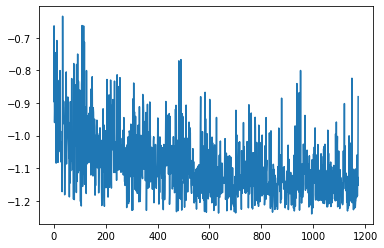

In [97]:
plt.plot(cumloss)
plt.show()

In [87]:
# manual test loss calculation

T = 255#50      # Input sequence length
C = 63      # Number of classes (including blank)
N = 2#16      # Batch size
S = 100#30      # Target sequence length of longest target in batch (padding length)
S_min = 10  # Minimum target length, for demonstration purposes

# Initialize random batch of input vectors, for *size = (T,N,C)
outputs = torch.randn(T, N, C).log_softmax(2).detach().requires_grad_()

# Initialize random batch of targets (0 = blank, 1:C = classes)
labels = torch.randint(low=1, high=C, size=(N, S), dtype=torch.long)

input_lengths = torch.full(size=(N,), fill_value=T, dtype=torch.long)
#target_lengths = torch.randint(low=S_min, high=S, size=(N,), dtype=torch.long)
target_lengths = torch.randint(low=100, high=101, size=(N,), dtype=torch.long)

print(outputs)
print(labels)
print("outshape: ", outputs.shape)
print("label shape:", labels.shape)
print("input_lengths: ", input_lengths)  
print("target_lengths: ", target_lengths)    


loss = criterion(outputs, labels, input_lengths, target_lengths)
loss.backward()

print(loss)

tensor([[[-4.4306, -4.0998, -4.1233,  ..., -3.3238, -5.6915, -4.9126],
         [-5.5885, -5.0159, -6.0364,  ..., -3.9779, -5.1057, -4.5169]],

        [[-5.4672, -4.1723, -5.8682,  ..., -4.7579, -4.6420, -3.9538],
         [-5.2610, -4.3299, -3.8197,  ..., -5.7619, -1.4759, -5.3554]],

        [[-5.6662, -4.6231, -3.5236,  ..., -5.4471, -5.1432, -4.6763],
         [-8.1536, -4.4242, -3.1889,  ..., -5.9822, -6.3128, -6.2531]],

        ...,

        [[-4.5743, -5.4772, -4.1531,  ..., -3.7454, -2.8786, -4.0571],
         [-3.4086, -4.6142, -4.5546,  ..., -4.7313, -4.0995, -6.8686]],

        [[-2.7837, -5.0826, -3.3319,  ..., -4.8641, -4.3599, -4.5517],
         [-5.2063, -5.0267, -5.6758,  ..., -3.0715, -4.4319, -3.1151]],

        [[-2.2955, -4.3054, -4.8209,  ..., -4.3052, -4.1976, -4.7257],
         [-3.0769, -3.7282, -3.9560,  ..., -4.8828, -4.9508, -5.3104]]],
       requires_grad=True)
tensor([[ 6, 40,  7, 21,  6, 37, 47, 23, 60, 50, 17, 34, 53,  2, 14, 18, 21, 29,
          7, 3

# Test

Once the training is completed, we just need to upload the model and run from here.

In [ ]:
print('Avergae Dice Score is:',test_score)
print('Avergae Dice Loss is:',1-test_score)

#Post-Process